# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Mounted at /gdrive


In [ ]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_400_100_100.zip','.','zip')

# creeëren datasets

Maken van 3 datasets (train, validation, test), met een bepaalde image size (zie colab "Optimal image size") en een batch size.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/test",
    image_size=(180, 180),
    batch_size=32)

Found 800 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


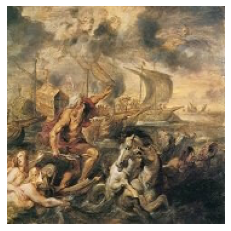

In [ ]:
import matplotlib.pyplot as plt
for images, _ in train_dataset.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.axis("off")

# Leren model

Maken model, met verschillende convnet layers.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

loss: bepalen van veschil tussen labels en predictie, binary_crossentropy is het negatieve gemiddelde van de log van de gecorrigeerde voorspelde kansen.

optimizer: is gelijkaardig aan gradient descent, de RMSprop-optimizer beperkt de oscillaties in verticale richting. Daarom kunnen we onze leersnelheid verhogen en zou ons algoritme grotere stappen in horizontale richting kunnen nemen en sneller convergeren.

---



In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Maak een callback om later het model te evalueren en om te achterhalen vanaf wanneer er aan overfitting plaats vindt.

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 8s 213ms/step - loss: 0.7416 - accuracy: 0.5475 - val_loss: 0.5936 - val_accuracy: 0.7250
Epoch 2/100
25/25 [==============================] - 6s 197ms/step - loss: 0.7705 - accuracy: 0.6850 - val_loss: 0.5103 - val_accuracy: 0.7450
Epoch 3/100
25/25 [==============================] - 6s 205ms/step - loss: 0.5419 - accuracy: 0.7375 - val_loss: 0.5099 - val_accuracy: 0.7000
Epoch 4/100
25/25 [==============================] - 6s 198ms/step - loss: 0.4823 - accuracy: 0.7650 - val_loss: 0.4846 - val_accuracy: 0.7700
Epoch 5/100
25/25 [==============================] - 6s 214ms/step - loss: 0.5627 - accuracy: 0.7650 - val_loss: 0.5008 - val_accuracy: 0.7000
Epoch 6/100
25/25 [==============================] - 6s 198ms/step - loss: 0.4662 - accuracy: 0.7713 - val_loss: 0.4021 - val_accuracy: 0.8300
Epoch 7/100
25/25 [==============================] - 6s 198ms/step - loss: 0.4601 - accuracy: 0.8138 - val_loss: 0.4092 - val_accuracy: 0.8150

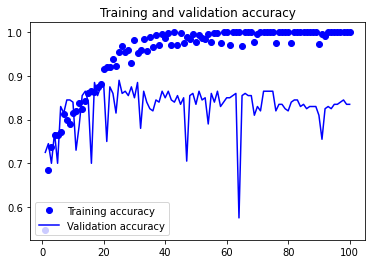

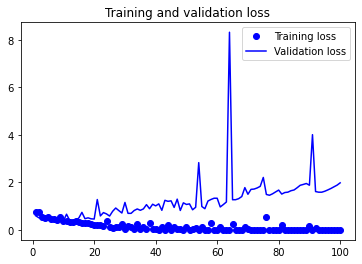

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We zien aan deze grafieken dat dit model aan overfitting doet na ongeveer 20-30 epochs.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 1s 29ms/step - loss: 0.4129 - accuracy: 0.8200
Test accuracy: 0.820


We zien hier dat we voor ons eerste erg basic model een accuracy bekomen van 82%, dit is al niet slecht maar dit kunnen we nog verbeteren door meerdere foto's zelf te generen door de bestaande foto's wat te augmenteren.

# Met data augmentation

Maken van data augmentation functie met keras, waarbij de foto horizontaal geflipt kan worden, licht kan gedraaid worden en kan licht ingezoomd worden.

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

voorbeeld:

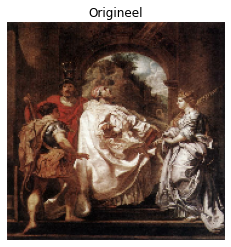

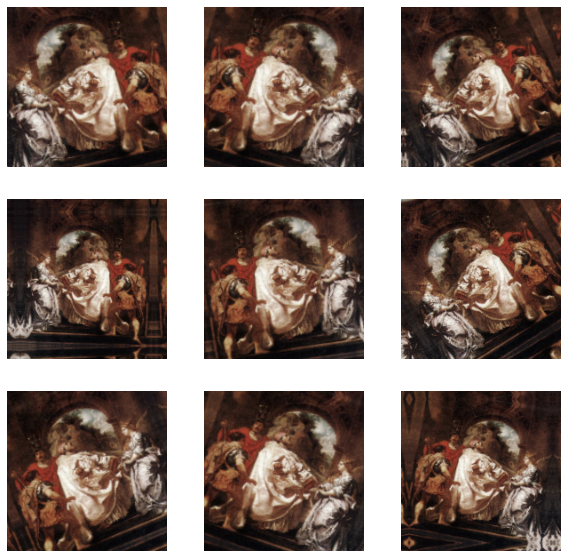

In [ ]:
import matplotlib.pyplot as plt

for images, _ in train_dataset.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title("Origineel")
  plt.axis("off")
  plt.plot()

  plt.figure(figsize=(10, 10))
  plt.title("Na augmentation")
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Nieuwe laag toegevoegd aan het model waarbij de data eerst geaugmenteerd wordt vooraleer deze wordt gebruikt om het model te trainen.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 8s 215ms/step - loss: 0.8437 - accuracy: 0.5525 - val_loss: 1.0368 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - 6s 204ms/step - loss: 1.1174 - accuracy: 0.6338 - val_loss: 0.5112 - val_accuracy: 0.7450
Epoch 3/100
25/25 [==============================] - 6s 200ms/step - loss: 0.5777 - accuracy: 0.7225 - val_loss: 0.6459 - val_accuracy: 0.6850
Epoch 4/100
25/25 [==============================] - 6s 201ms/step - loss: 0.5387 - accuracy: 0.7312 - val_loss: 1.6476 - val_accuracy: 0.5300
Epoch 5/100
25/25 [==============================] - 6s 202ms/step - loss: 0.5355 - accuracy: 0.7538 - val_loss: 0.4112 - val_accuracy: 0.7800
Epoch 6/100
25/25 [==============================] - 6s 200ms/step - loss: 0.5273 - accuracy: 0.7475 - val_loss: 1.2227 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================] - 6s 200ms/step - loss: 0.4878 - accuracy: 0.7975 - val_loss: 0.5367 - val_accuracy: 0.7600

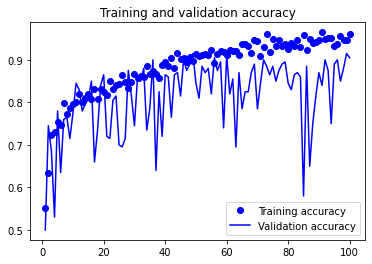

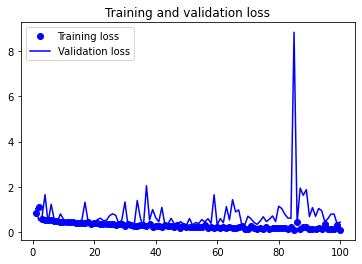

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Aan de grafieken kunnen we zien dat bij dit model de validation accuracy heel erg varieert per epoch, ook zien we dat de validation accuracy niet meer verhoogd na 40-50 epochs.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 1s 29ms/step - loss: 0.2568 - accuracy: 0.9050
Test accuracy: 0.905


We zien hier dat het augmenteren een groot verschil maakt in resultaat, de accuracy is verhoogd met 8.5% (van 82 naar 90.5), dit is al heel wat beter.
We kunnen nu deze techniek toepassen op een al eerder getraind model die gestript wordt.